In [1]:
from Utils import *

In [2]:
#dfs creation from npz
folder_path = r"C:\Users\stebi\Desktop\potatoes\1800"
dataframes = load_npz_files(folder_path)
for name, df in dataframes.items():
    globals()[name] = df

In [3]:
#check y max in each df
dataframe_names = [f"df{i}" for i in range(1, 33)]

for name in dataframe_names:
    df = globals()[name]
    if 'y' in df.columns:
        y_value = df.loc[0, 'y']
        print(f"{name} - y value in row 0: {y_value}")
    else:
        print(f"{name} does not have a 'y' column.")

df1 - y value in row 0: -69
df2 - y value in row 0: -76
df3 - y value in row 0: -45
df4 - y value in row 0: -67
df5 - y value in row 0: -42
df6 - y value in row 0: -64
df7 - y value in row 0: -62
df8 - y value in row 0: -55
df9 - y value in row 0: -144
df10 - y value in row 0: -204
df11 - y value in row 0: -180
df12 - y value in row 0: -143
df13 - y value in row 0: -114
df14 - y value in row 0: -181
df15 - y value in row 0: -174
df16 - y value in row 0: -130
df17 - y value in row 0: -123
df18 - y value in row 0: -127
df19 - y value in row 0: -138
df20 - y value in row 0: -106
df21 - y value in row 0: -162
df22 - y value in row 0: -132
df23 - y value in row 0: -106
df24 - y value in row 0: -136
df25 - y value in row 0: -54
df26 - y value in row 0: -52
df27 - y value in row 0: -54
df28 - y value in row 0: -43
df29 - y value in row 0: -55
df30 - y value in row 0: -69
df31 - y value in row 0: -58
df32 - y value in row 0: -59


In [4]:
df1

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x1792,x1793,x1794,x1795,x1796,x1797,x1798,x1799,x1800,y
0,97.256714,109.217660,108.177720,110.046720,111.929620,113.559700,115.110200,116.551600,117.922420,119.223114,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-69
1,135.700580,135.549320,135.346160,135.170640,135.020170,134.848880,134.601290,134.442780,134.242870,134.050780,...,9.868005,9.852276,9.816974,9.782293,9.700430,9.679945,9.688729,9.622552,9.602593,-69
2,9.578903,9.526599,9.494160,9.464470,9.434893,9.427804,9.392871,9.344328,9.308388,9.259672,...,-16.482183,-16.470444,-16.422170,-16.474878,-16.486914,-16.491713,-16.491026,-16.491032,-16.503109,-69
3,-16.513840,-16.533766,-16.540901,-16.550737,-16.553303,-16.564280,-16.555020,-16.554382,-16.578356,-16.570112,...,-27.333277,-27.337494,-27.349640,-27.378326,-27.389366,-27.373075,-27.376266,-27.378641,-27.393843,-69
4,-27.412397,-27.448242,-27.443336,-27.450314,-27.465702,-27.474468,-27.468273,-27.471638,-27.469805,-27.470478,...,-34.502663,-34.514355,-34.519485,-34.522392,-34.513977,-34.524544,-34.507244,-34.500763,-34.506233,-69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5706,-43.059860,-43.060944,-43.066000,-43.049225,-43.058987,-43.070698,-43.051693,-43.047090,-43.051006,-43.048805,...,-43.122772,-43.127860,-43.137302,-43.132412,-43.117374,-43.118380,-43.153930,-43.136320,-43.122925,50
5707,-43.133860,-43.124810,-43.122246,-43.128620,-43.138603,-43.110493,-43.118230,-43.114530,-43.151154,-43.126816,...,-43.235577,-43.234085,-43.226307,-43.226593,-43.229260,-43.223568,-43.221080,-43.225350,-43.232190,50
5708,-43.236350,-43.258070,-43.237976,-43.241530,-43.243073,-43.243843,-43.235367,-43.222744,-43.216045,-43.243088,...,-43.249615,-43.250040,-43.256466,-43.232464,-43.207592,-43.221073,-43.214375,-43.218887,-43.213074,50
5709,-43.188545,-43.185560,-43.217820,-43.215878,-43.198994,-43.224888,-43.216103,-43.216553,-43.229237,-43.215015,...,-43.296200,-43.268800,-43.289883,-43.305720,-43.284767,-43.293180,-43.303246,-43.298733,-43.310486,50


In [5]:
df32

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x1792,x1793,x1794,x1795,x1796,x1797,x1798,x1799,x1800,y
0,-30.770640,-33.980423,-33.078950,-33.179450,-33.302380,-33.306168,-33.294594,-33.294502,-33.338710,-33.266064,...,-33.484623,-33.714317,-33.754032,-33.524630,-33.390900,-33.321114,0.000000,0.000000,0.000000,-59
1,-33.245260,-33.207718,-33.295082,-33.540080,-33.527504,-33.440994,-33.426926,-33.365486,-33.541620,-33.428684,...,-32.730686,-32.684280,-32.648304,-32.638073,-32.635494,-32.641150,-32.630640,-32.643383,-32.610977,-59
2,-32.593422,-30.358680,-33.401700,-32.515373,-32.535145,-32.539658,-32.561690,-32.559845,-32.545235,-32.540200,...,-32.178368,-32.169907,-32.189014,-32.172250,-32.202705,-32.187820,-32.210007,-32.214810,-32.220097,-59
3,-32.228676,-32.243935,-32.254295,-32.256145,-32.257114,-32.253850,-32.245630,-32.243748,-32.293728,-32.349915,...,-33.140785,-33.141865,-33.130280,-33.135790,-33.124660,-33.101360,-33.078793,-33.054066,-33.066067,-59
4,-33.066160,-33.029760,-33.026203,-32.998478,-32.999706,-33.005135,-32.985794,-33.013160,-32.967945,-32.974510,...,-35.932003,-35.923367,-35.931942,-35.923004,-35.917380,-35.909830,-35.693447,-35.689910,-35.799480,-59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5682,-46.202307,-46.202370,-46.202433,-46.202495,-46.202558,-46.202621,-46.202683,-46.202746,-46.202809,-46.202871,...,-46.314498,-46.314560,-46.314623,-46.314685,-46.314748,-46.314811,-46.314873,-46.314936,-46.314999,60
5683,-46.315061,-46.315124,-46.315187,-46.315249,-46.315312,-46.315375,-46.315437,-46.315500,-46.315562,-46.315625,...,-46.427251,-46.427314,-46.427377,-46.427439,-46.427502,-46.427565,-46.427627,-46.427690,-46.427753,60
5684,-46.427815,-46.427878,-46.427940,-46.428003,-46.428066,-46.428128,-46.428191,-46.428254,-46.428316,-46.428379,...,-46.540005,-46.540068,-46.540131,-46.540193,-46.540256,-46.540319,-46.540381,-46.540444,-46.540506,60
5685,-46.540569,-46.540632,-46.540694,-46.540757,-46.540820,-46.540882,-46.540945,-46.541008,-46.541070,-46.541133,...,-46.519726,-46.523857,-46.506245,-46.502632,-46.504677,-46.497433,-46.493725,-46.493202,-46.488330,60


In [6]:
#nans all dfs
dataframe_names = [f'df{i}' for i in range(1, 33)]
nan_report = {}

for name in dataframe_names:
    df = globals().get(name)
    if df is not None and isinstance(df, pd.DataFrame):
        nan_columns = df.columns[df.isna().any()].tolist()
        if nan_columns:
            nan_report[name] = nan_columns

if not nan_report:
    print("No nans.")
else:
    print("Nans in this df:")
    for name, columns in nan_report.items():
        print(f"{name} is column: {columns}")

No nans.


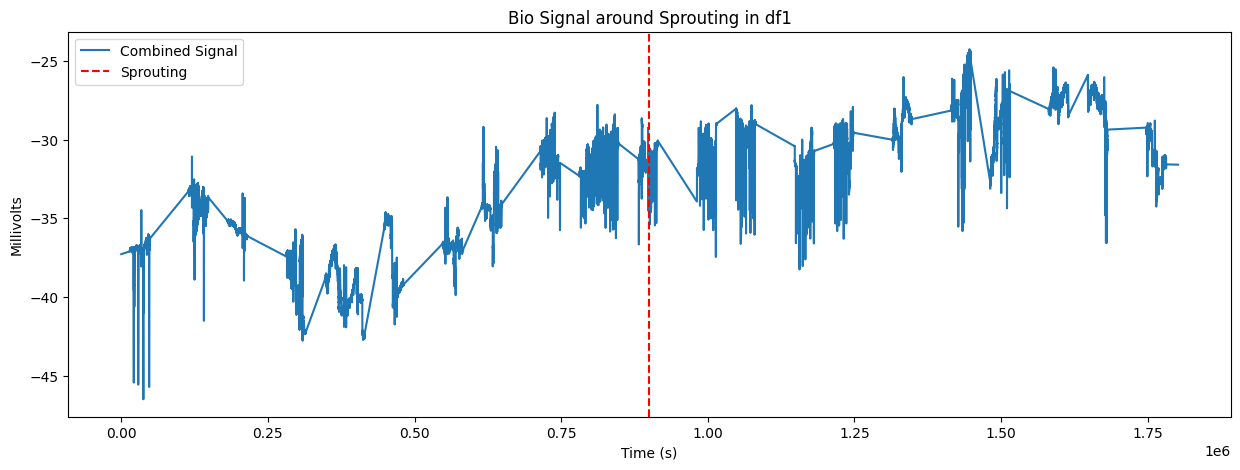

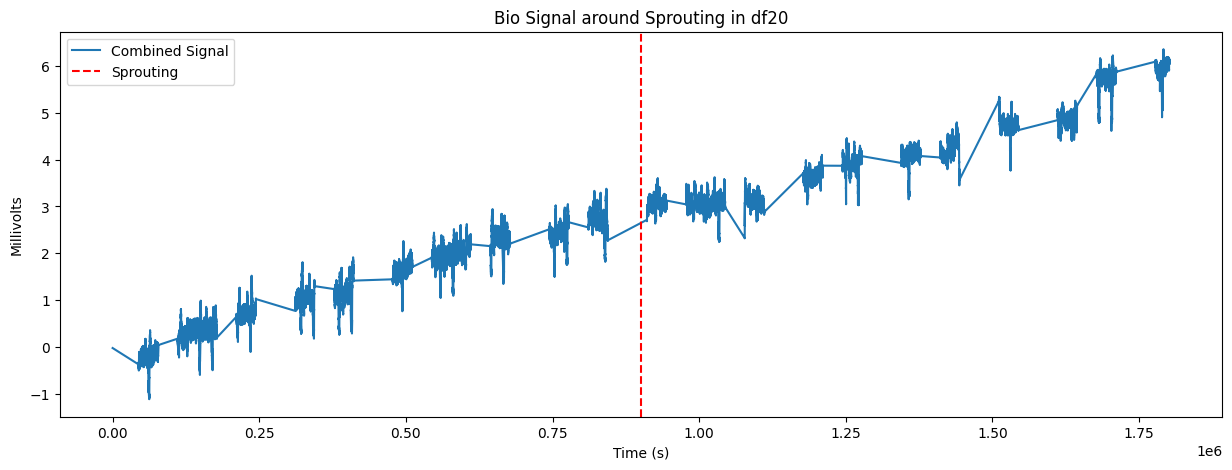

In [7]:
#500 steps before and after sprouting, see a pattern?
plot_bio_signal(df1, 'df1')
plot_bio_signal(df20, 'df20')

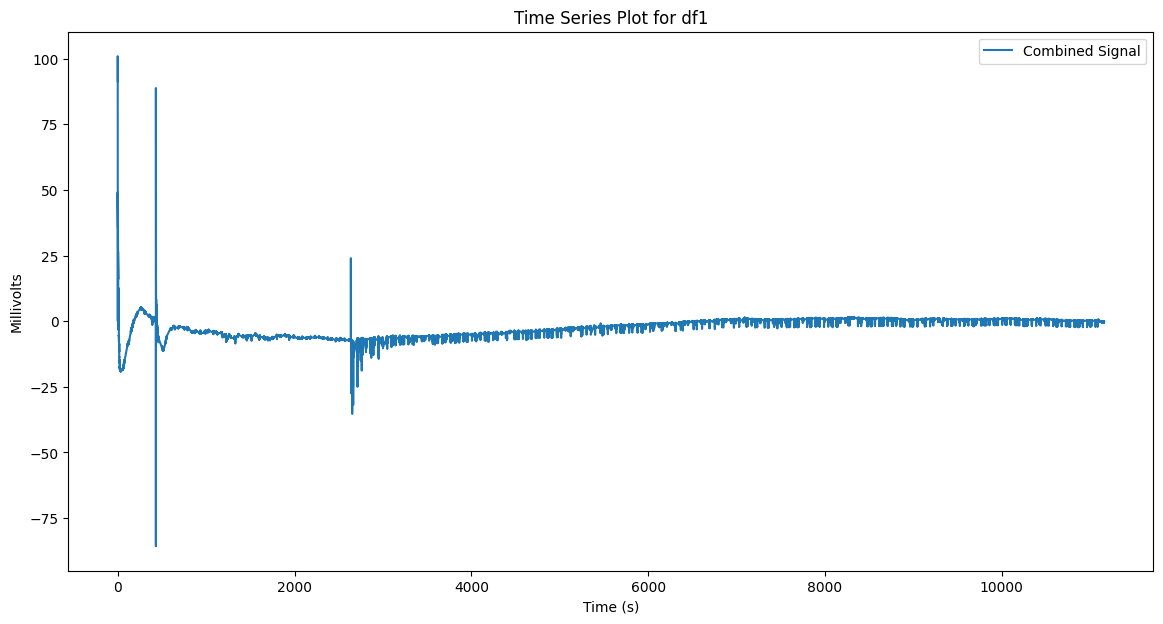

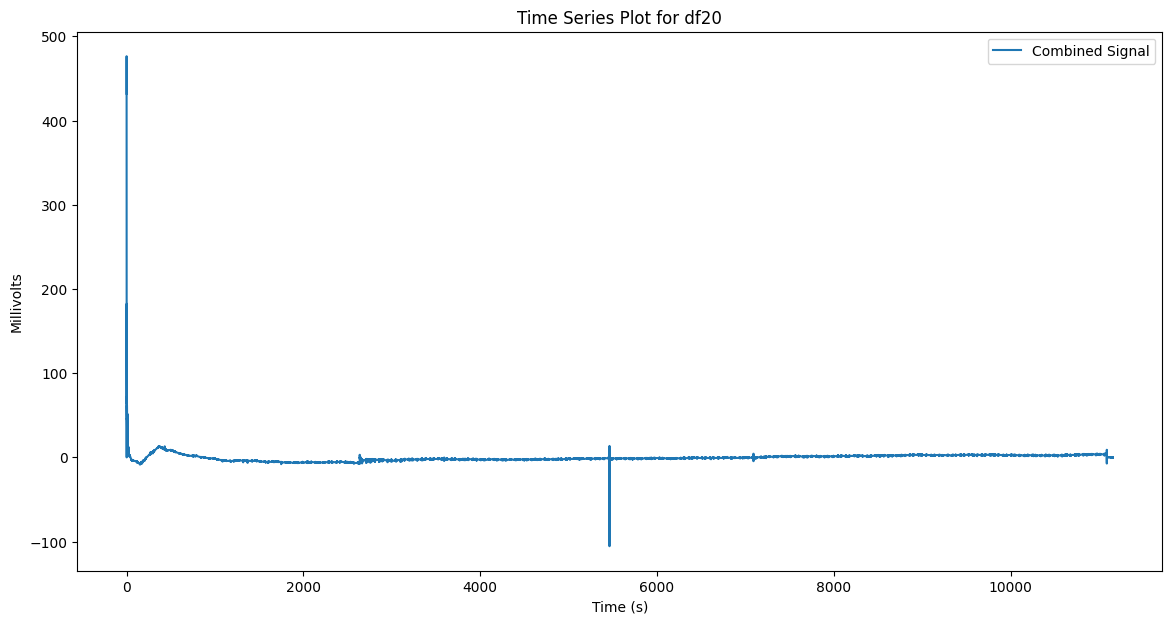

In [8]:
plot_time_series(df10, 'Time Series Plot for df1')
plot_time_series(df15, 'Time Series Plot for df20')

In [9]:
#keep only rows for y<=0
dataframe_names = [f'df{i}' for i in range(1, 33)]  

filtered_dataframes = {}

for name in dataframe_names:
    df = globals().get(name)  
    if df is not None and isinstance(df, pd.DataFrame):
        filtered_df = df.loc[df['y'] <= 0]
        filtered_dataframes[name] = filtered_df  
        print(f"First few rows of {name}:")
        print(filtered_df.head())  

First few rows of df1:
           x1          x2          x3          x4          x5          x6  \
0   97.256714  109.217660  108.177720  110.046720  111.929620  113.559700   
1  135.700580  135.549320  135.346160  135.170640  135.020170  134.848880   
2    9.578903    9.526599    9.494160    9.464470    9.434893    9.427804   
3  -16.513840  -16.533766  -16.540901  -16.550737  -16.553303  -16.564280   
4  -27.412397  -27.448242  -27.443336  -27.450314  -27.465702  -27.474468   

           x7          x8          x9         x10  ...      x1792      x1793  \
0  115.110200  116.551600  117.922420  119.223114  ...   0.000000   0.000000   
1  134.601290  134.442780  134.242870  134.050780  ...   9.868005   9.852276   
2    9.392871    9.344328    9.308388    9.259672  ... -16.482183 -16.470444   
3  -16.555020  -16.554382  -16.578356  -16.570112  ... -27.333277 -27.337494   
4  -27.468273  -27.471638  -27.469805  -27.470478  ... -34.502663 -34.514355   

       x1794      x1795      x179

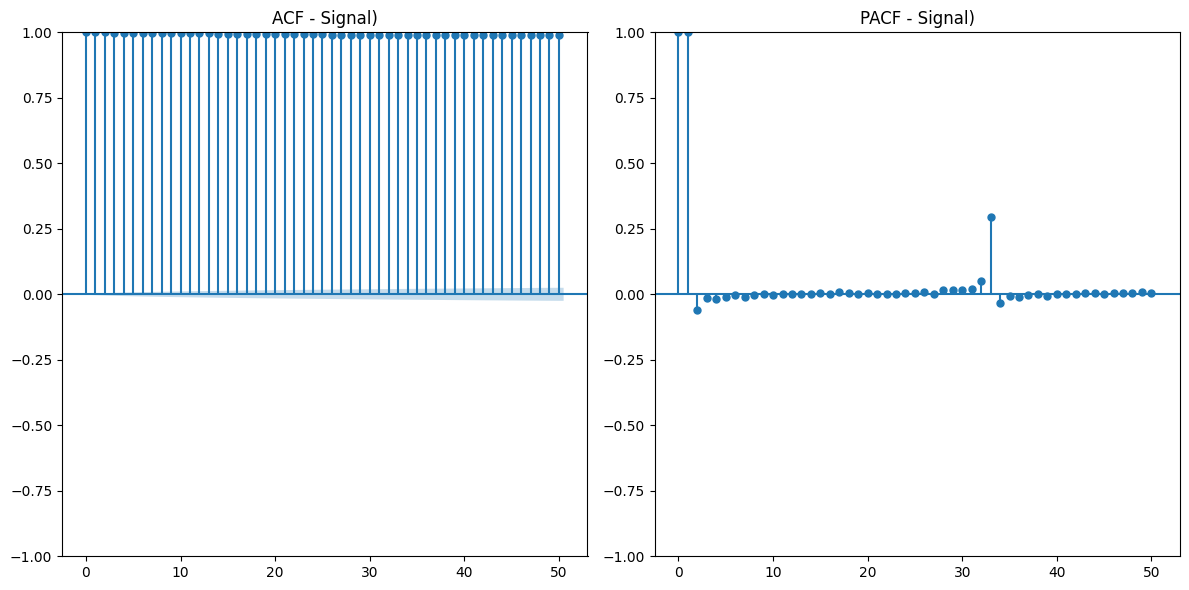

In [10]:
#ACF e PACF
filtered_df1 = df1.loc[df1['y'] <= 0]
combined_signal = filtered_df1.drop(columns='y', errors='ignore').values.flatten()
downsampled_signal = downsample_signal(combined_signal, factor=10) 
plot_acf_pacf(downsampled_signal, 'Signal)')

In [11]:
#check stationarity
stationarity_results_df1 = check_combined_stationarity_kpss(df1)
for key, value in stationarity_results_df1.items():
    print(f"{key}: {value}")

Test Statistic: 48.294028615659315
p-value: 0.01
Lags Used: 1724
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Stationarity: Non-stationary


c:\Users\stebi\Desktop\TESI\Thesis\Utils\stationarity.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(combined_signal, regression='c', nlags='auto')


In [12]:
#box-cox for normalization 
transformed_dataframes = {}
for name, df in filtered_dataframes.items():
    transformed_df = apply_box_cox(df, target='y')
    transformed_dataframes[name] = transformed_df 

In [13]:
#anomaly detection +/- 4 stdev
cleaned_dataframes = {}

for name, df in transformed_dataframes.items():
    if df is not None and isinstance(df, pd.DataFrame):
        print(f"Processing {name} with shape {df.shape}")  
        try:
            cleaned_df = detect_replace_outliers(df)
            cleaned_dataframes[name] = cleaned_df 
            print(f"Outliers detected and replaced in {name}")
        except KeyError as e:
            print(f"KeyError encountered while processing {name}: {e}")
            print("DataFrame columns:", df.columns)
            print("DataFrame head:")
            print(df.head())
        except IndexError as e:
            print(f"IndexError encountered while processing {name}: {e}")


Processing df1 with shape (3337, 1801)
Outliers detected and replaced in df1
Processing df2 with shape (3685, 1801)
Outliers detected and replaced in df2
Processing df3 with shape (2185, 1801)
Outliers detected and replaced in df3
Processing df4 with shape (3253, 1801)
Outliers detected and replaced in df4
Processing df5 with shape (2041, 1801)
Outliers detected and replaced in df5
Processing df6 with shape (3073, 1801)
Outliers detected and replaced in df6
Processing df7 with shape (3001, 1801)
Outliers detected and replaced in df7
Processing df8 with shape (2665, 1801)
Outliers detected and replaced in df8
Processing df9 with shape (6956, 1801)
Outliers detected and replaced in df9
Processing df10 with shape (9796, 1801)
Outliers detected and replaced in df10
Processing df11 with shape (8664, 1801)
Outliers detected and replaced in df11
Processing df12 with shape (6872, 1801)
Outliers detected and replaced in df12
Processing df13 with shape (5513, 1801)
Outliers detected and replaced

In [14]:
#detrend wavelet
detrended_dataframes_continuous = {}
detrended_dataframes_linear = {}

for name, df in cleaned_dataframes.items():
    detrended_df_continuous = detrend_signal_wavelet_cont(df)
    detrended_dataframes_continuous[name] = detrended_df_continuous
    detrended_df_linear = detrend_signal_wavelet_linear(df)
    detrended_dataframes_linear[name] = detrended_df_linear

In [15]:
#plot detrended
#plot_detrended_signal(detrended_df1, 'df1')

In [16]:
#feature generation
augmented_features_continuous = {}
augmented_features_linear = {}
augmented_features_cleaned = {}

for name, df in detrended_dataframes_continuous.items():
    features_df = extract_features(df)
    augmented_features_continuous[name] = features_df

for name, df in detrended_dataframes_linear.items():
    features_df = extract_features(df)
    augmented_features_linear[name] = features_df

for name, df in cleaned_dataframes.items():
    features_df = extract_features(df)
    augmented_features_cleaned[name] = features_df

c:\Users\stebi\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
c:\Users\stebi\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_stats_py.py:1203: RuntimeWarning: overflow encountered in square
  s = s**2
c:\Users\stebi\Desktop\TESI\Thesis\Utils\featgen.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return func(data)
c:\Users\stebi\Desktop\TESI\Thesis\Utils\featgen.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return func(data)
c:\Users\stebi\Desktop\TESI\Thesis\Utils\featgen.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrop

In [17]:
#check shapes
first_df_continuous_shape = next(iter(augmented_features_continuous.values())).shape
print("First dataframe in detrended_dataframes_continuous:", first_df_continuous_shape)

first_df_linear_shape = next(iter(augmented_features_linear.values())).shape
print("First dataframe in detrended_dataframes_linear:", first_df_linear_shape)

first_df_cleaned_shape = next(iter(augmented_features_cleaned.values())).shape
print("First dataframe in cleaned_dataframes:", first_df_cleaned_shape)

First dataframe in detrended_dataframes_continuous: (3337, 30)
First dataframe in detrended_dataframes_linear: (3337, 30)
First dataframe in cleaned_dataframes: (3337, 30)


In [18]:
#scaling all features 
all_dictionaries = {
    'augmented_features_continuous': augmented_features_continuous,
    'augmented_features_linear': augmented_features_linear,
    'augmented_features_cleaned': augmented_features_cleaned
}

def scale_all_dictionaries(dicts, target='y'):
    scaled_dicts = {}
    for dict_name, datasets in dicts.items():
        scaled_dicts[dict_name] = {}
        for df_name, df in datasets.items():
            scaled_df = scale_features(df, target)
            scaled_dicts[dict_name][df_name] = scaled_df
    return scaled_dicts

scaled_dictionaries = scale_all_dictionaries(all_dictionaries)

In [19]:
#correlations wrt y target
top_correlations_dict = get_top_correlations_for_all(scaled_dictionaries, target_column='y', num_top=30)
summary_df = summarize_top_correlations(top_correlations_dict)
display_top_correlations_summary(summary_df, num_features=10)

Top Correlations Summary:

Dictionary: augmented_features_continuous
  DataFrame: df1
                    Feature  Correlation
0               global_skew     0.279313
1           global_kurtosis     0.267184
2  global_envelope_kurtosis     0.261485
3      global_envelope_skew     0.259090
4                global_max     0.182275
5              global_range     0.179528
6                global_min     0.177573
7       global_envelope_max     0.176945
8                global_var     0.170103
9       global_total_energy     0.170103
  DataFrame: df2
                      Feature  Correlation
29   global_envelope_kurtosis     0.267427
30         global_quantile_25     0.264691
31           global_iqr_25_75     0.262349
32           global_iqr_10_90     0.261164
33         global_quantile_75     0.260434
34                global_mean     0.256252
35       global_envelope_skew     0.254733
36            global_kurtosis     0.222317
37                global_skew     0.184899
38  global_mean_

Processing dictionary: augmented_features_continuous
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 152064, number of used features: 29
[LightGBM] [Info] Start training from score -61.952099
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 151716, number of used features: 29
[LightGBM] [Info] Start training from score -61.927582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007340 seconds.
You can set `force_row_wi

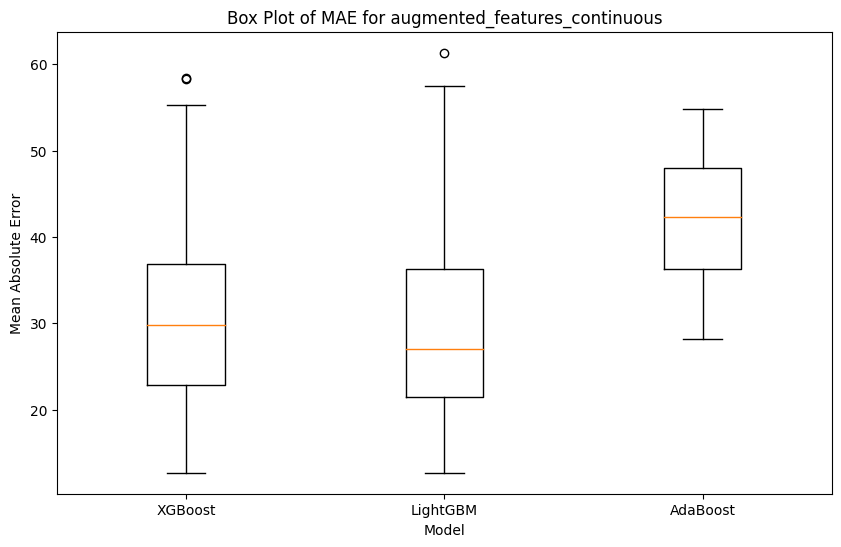

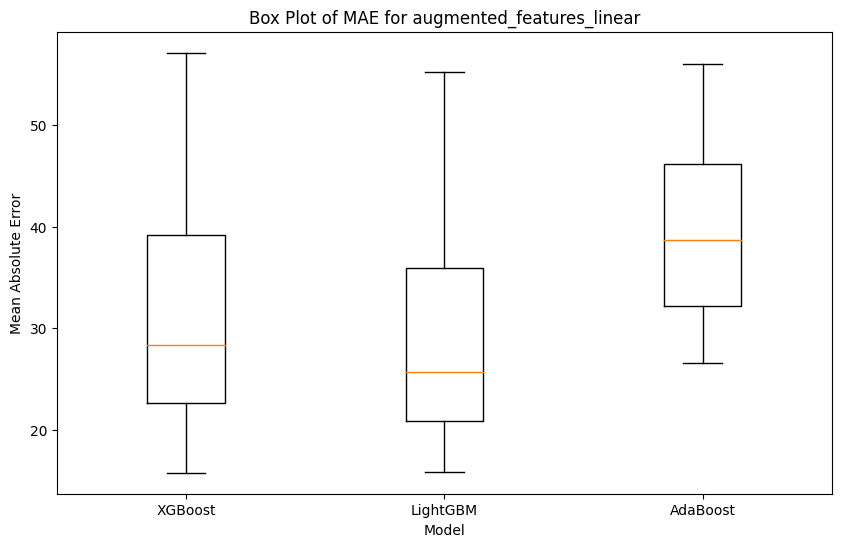

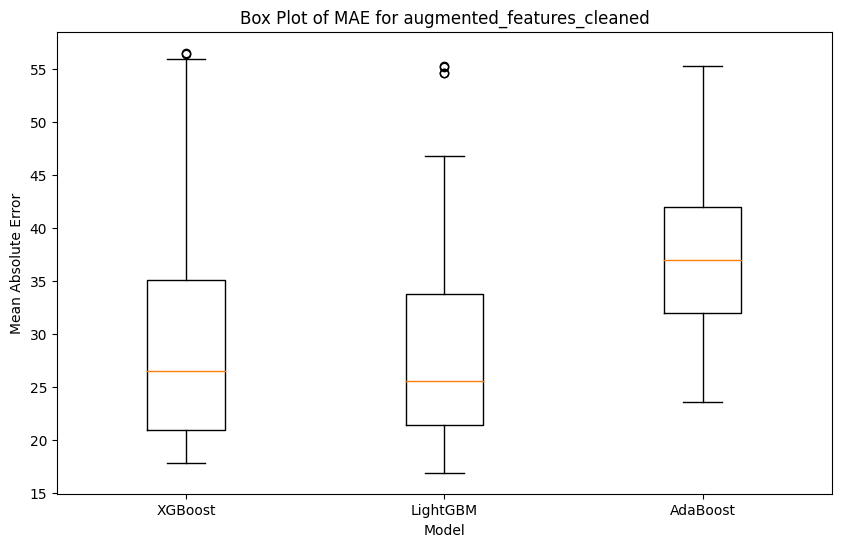

In [20]:
#modelling, no opt
"""
I performed regression and cross-validation using Leave-One-Out (LOO) on different models 
(XGBoost, LightGBM, AdaBoost) across various datasets. The MAE for each model was calculated and 
stored for each dataset. Additionally, I averaged the actual and predicted values for each dictionary 
to compare overall trends. 
The results and predictions were stored in dictionaries for further analysis
"""
results, predictions = perform_regression_and_cv(scaled_dictionaries)
print_results(results, "MAE")
plot_box_plots(results)

Processing dictionary: augmented_features_linear
Optimizing XGBoost...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Optimizing XGBoost...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for ea

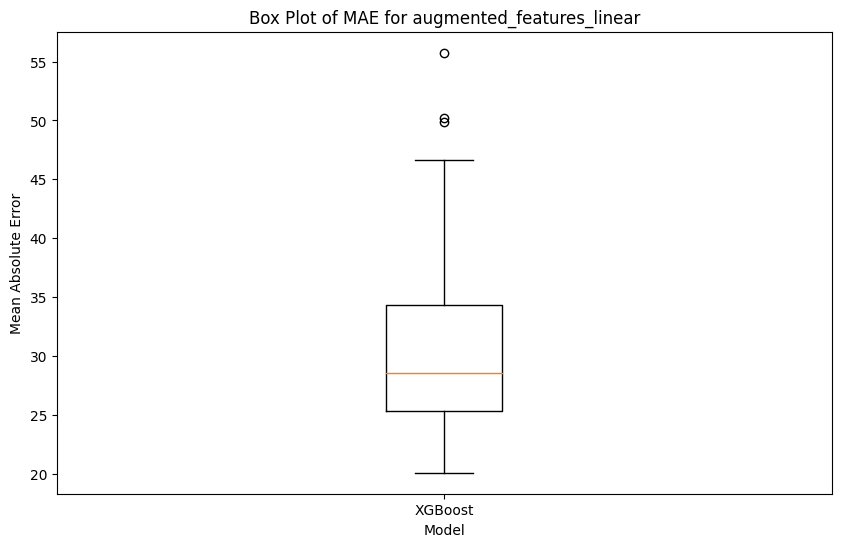

In [21]:
#Modelling, BO
"""
I performed regression and cross-validation using Leave-One-Out (LOO) on the 'augmented_features_linear' 
dictionary. XGBoost was optimized using Bayesian Optimization, and the best model was trained on the training 
data. MAE was calculated for each prediction and stored in results. 
The actual and predicted values were plotted to visualize the performance of the model.
"""
results, predictions = bayesian_optimization(scaled_dictionaries)
print_results(results, "MAE")
plot_box_plots(results)

In [22]:
#modelling with MC dropout
"""
This script performs regression using MC Dropout with XGBoost. The MC Dropout XGBRegressor 
adds dropout during prediction to estimate uncertainty by running multiple iterations with 
randomly dropped out input features. The mean and percentiles of the predictions provide a mean 
prediction and uncertainty range. Unreliable predictions are identified based on uncertainty thresholds. 
The model is evaluated using Leave-One-Out Cross-Validation (LOO CV) on the entire dataset, considering 
each row's 'y' value as a target. The results and predictions are printed and plotted, showing the model's 
performance and comparing actual vs. predicted values with uncertainty intervals.
"""
results, predictions = mc_dropout(scaled_dictionaries)
print_results(results, "MAE")

Processing dictionary: augmented_features_continuous
Testing parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.8}
Testing parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 1.0}
Testing parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'subsample': 0.8}
Testing parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'subsample': 1.0}
Testing parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'subsample': 0.8}
Testing parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'subsample': 1.0}
Testing parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'subsample': 0.8}
Testing parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'subsample': 1.0}
Testing parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'subsample': 0.8}
Testing parameters: 

Processing dictionary: augmented_features_continuous
Optimizing XGBoost parameters...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Optimizing XGBoost parameters...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Optimizing XGBoost parameters...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Optimizing XGBoost parameters...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Optimizing XGBoost parameters...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Optimizing XGBoost parameters...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Optimizing XGBoost parameters...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Optimizing XGBoost parameters...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Optimizing XGBoost parameters...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Optimizing XGBoost parameters...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Optimiz

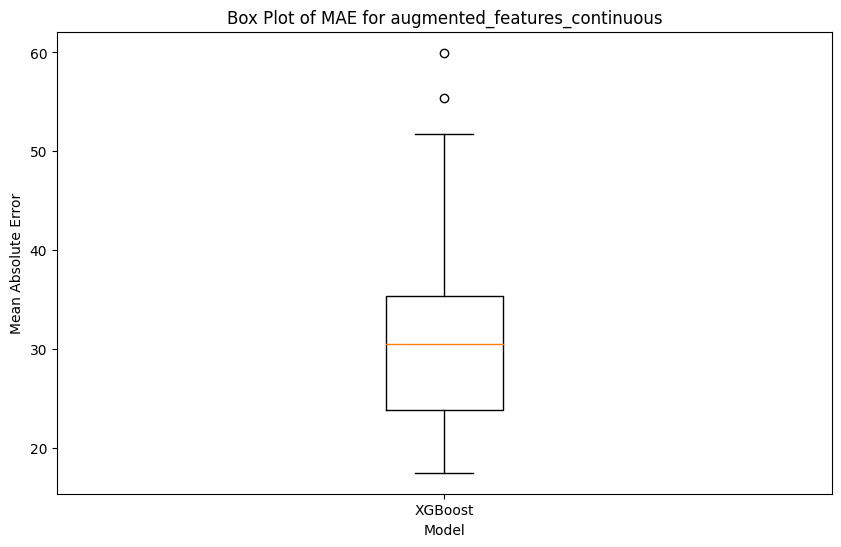

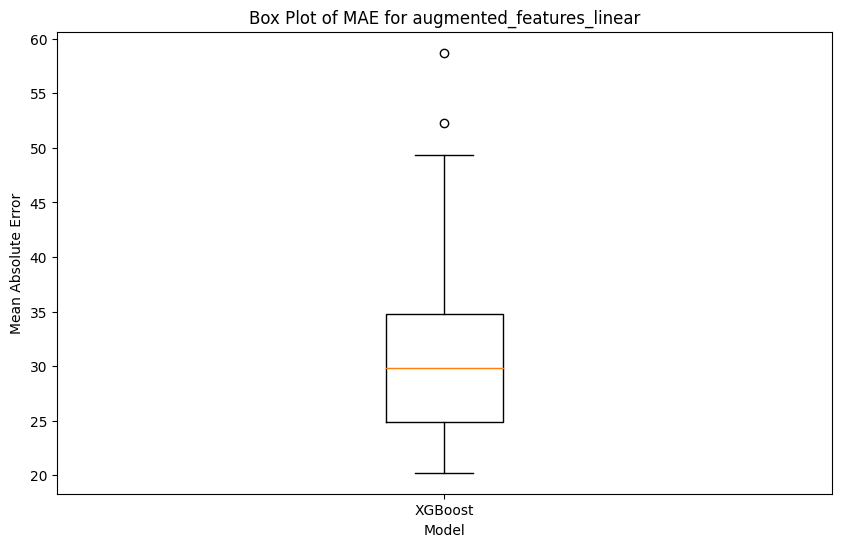

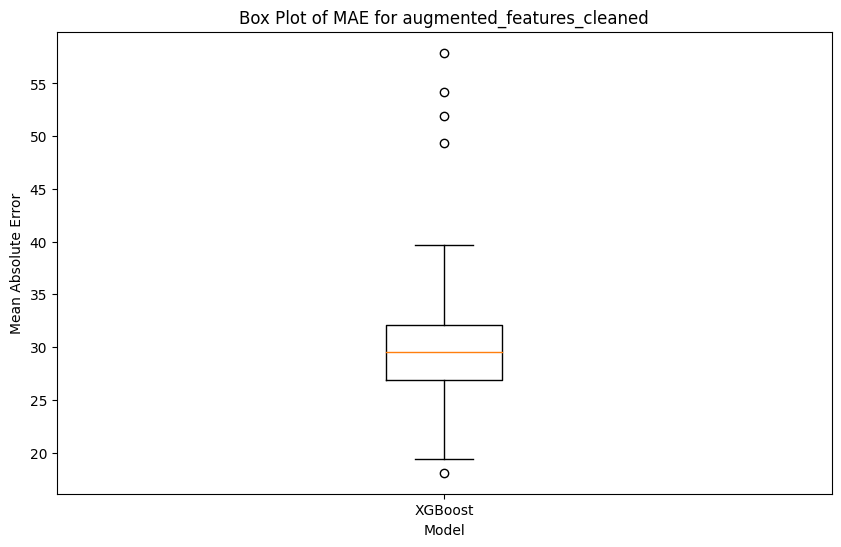

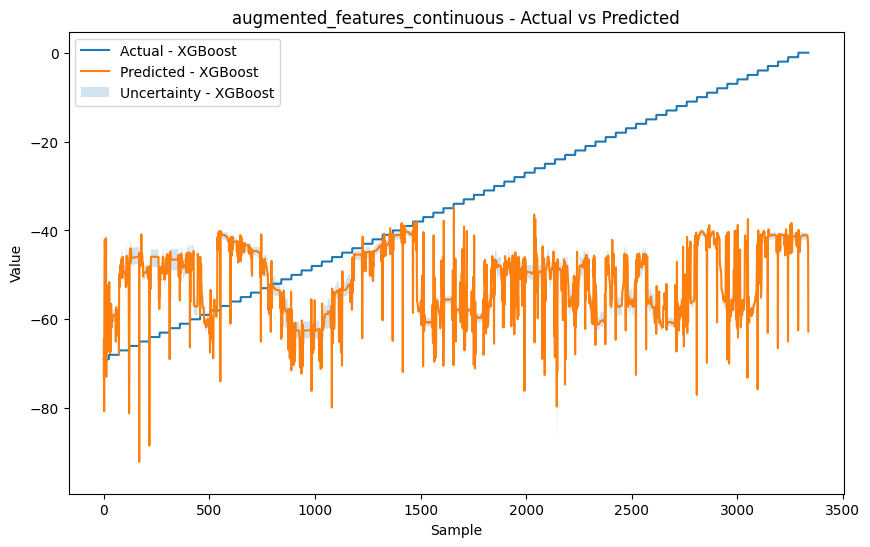

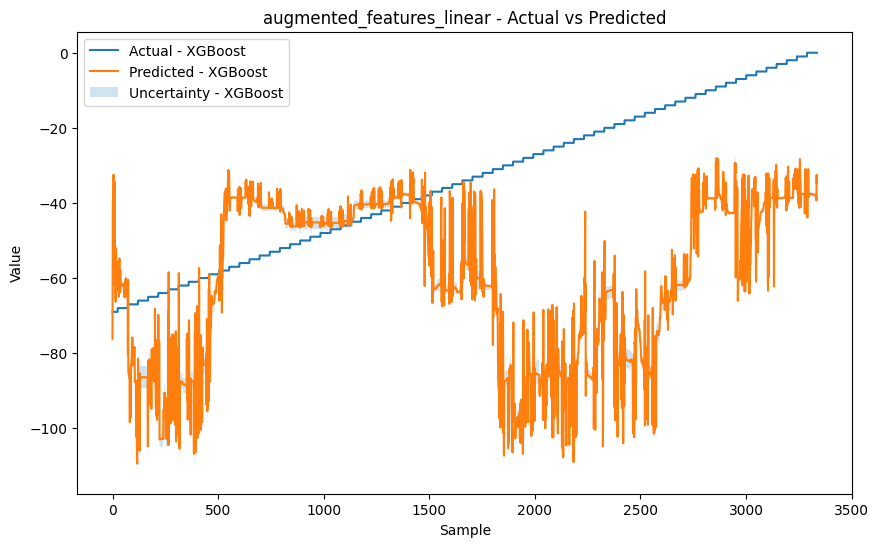

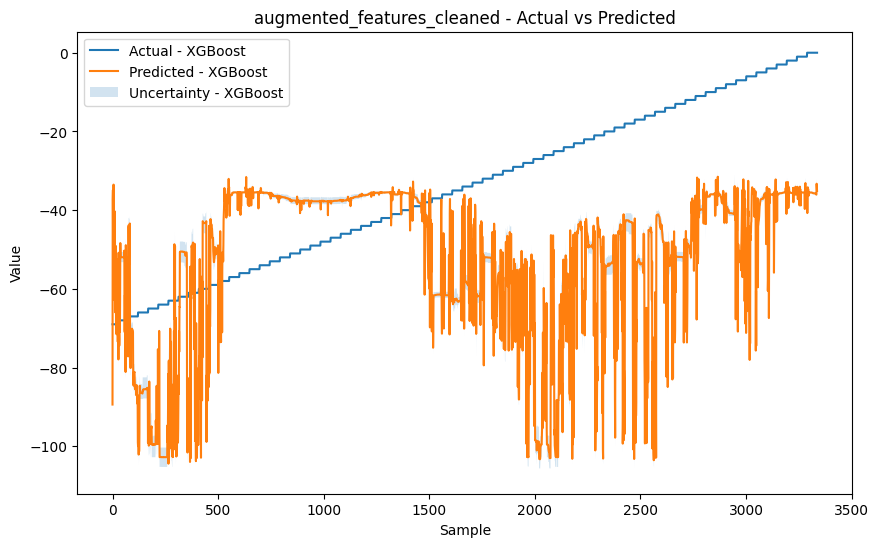

In [23]:
#bootstrapping
"""
This script conducts regression using XGBoost, incorporating bootstrapping to estimate uncertainty. 
It starts by creating multiple models from resampled training data. Predictions are generated from 
these models, and the average prediction and uncertainty bounds are computed. XGBoost parameters are 
optimized using Bayesian optimization. The process involves Leave-One-Out Cross-Validation, training
models, and predicting for each split, with predictions accepted or rejected based on uncertainty thresholds.
The script then outputs results, including mean absolute errors, and 
generates plots comparing actual vs. predicted values, highlighting the uncertainty intervals.
"""
results, predictions = perform_regression_and_cv_with_bootstrap(scaled_dictionaries)
print_results(results, "MAE")
plot_box_plots(results)
plot_predictions_vs_actuals(predictions)

Processing dictionary: augmented_features_continuous
Processing dictionary: augmented_features_linear
Processing dictionary: augmented_features_cleaned

MAE Results:

Dictionary: augmented_features_continuous
  Model: XGBoost, MAE: 31.0874

Dictionary: augmented_features_linear
  Model: XGBoost, MAE: 31.9915

Dictionary: augmented_features_cleaned
  Model: XGBoost, MAE: 30.9563


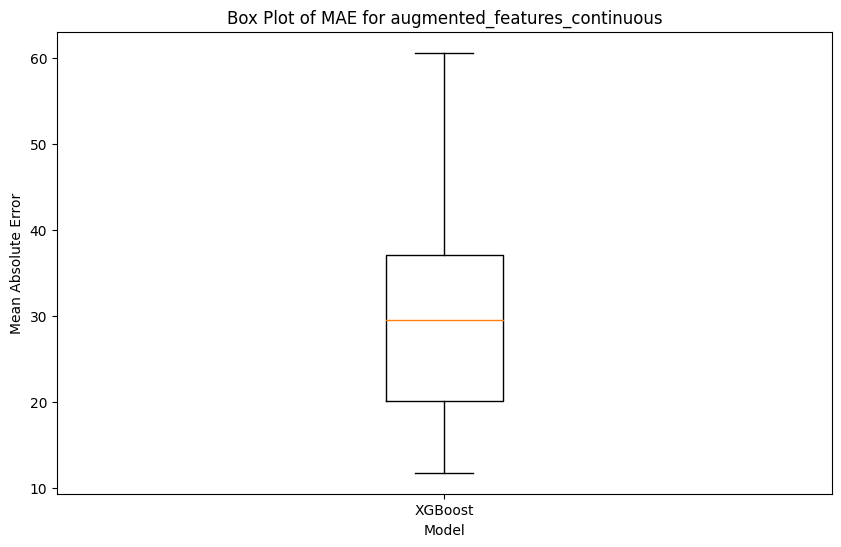

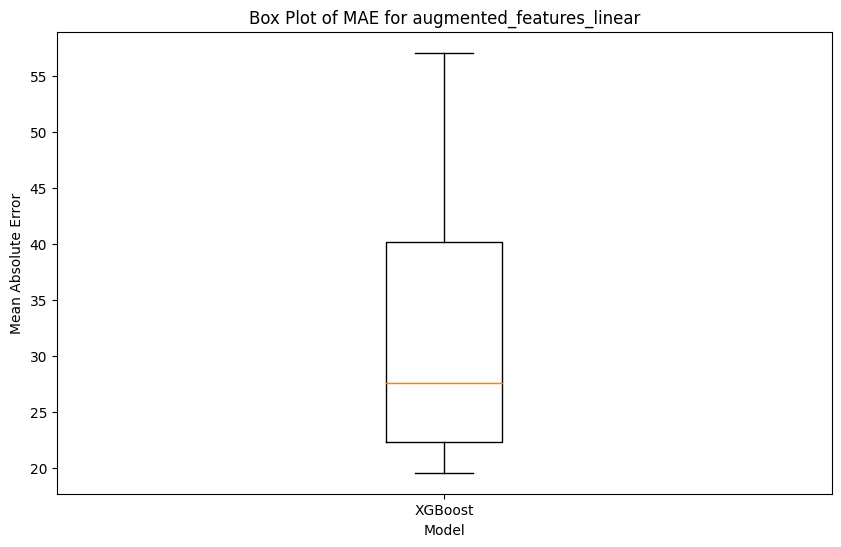

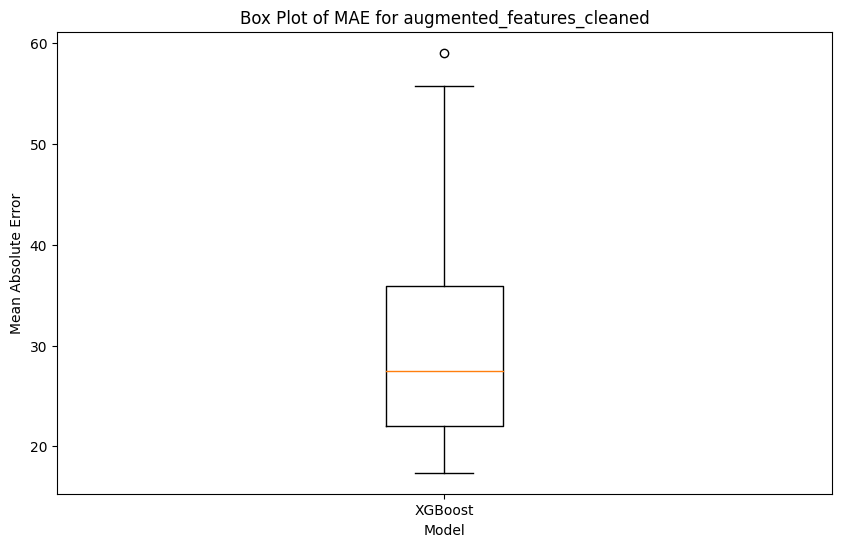

In [24]:
#conformal prediction
"""
This script implements conformal prediction using XGBoost to estimate uncertainty. The model is 
trained on a portion of the training data, with residuals calculated from predictions on a calibration
set. These residuals determine the uncertainty bounds. Predictions and their confidence intervals
are then generated for the test set. Using Leave-One-Out Cross-Validation, the process involves
training models, predicting, and calculating mean absolute errors for each split, while excluding
predictions with high uncertainty. The script outputs results, including mean absolute errors, and
generates plots comparing actual vs. predicted values, highlighting the uncertainty intervals.
"""
results, predictions = perform_conformal_prediction(scaled_dictionaries)
print_results(results, "MAE")
plot_box_plots(results)